### Miniproject
The following Molecular Dynamics code simulates the equilibrium dynamics of liquid argon atoms (for which the LJ interaction potential is a very good model) in 2D at fixed density and temperature (NVT) ensemble. 

Run this simulation at different values of density (Dens) and temperature (Temp)  and predict from the resulting radial distribution function, $g(r)$, whether the system is in Solid, Liquid or Gas phase.  

Molecular Dynamics for 216 LJ Atoms
Using Temperature scaling during equilibration
Fixed Density with truncated potential
Density=  1.000 (g/cm^3)  Temperature=150.000 (K)
Timestep= 0.004
    Step   Etotal       Temp    <Temp>    Epot     <Epot>     Press    <Press>
      20  -2.99303    1.2168    1.2455   -4.8182   -5.0650   -1.7777   -3.1420
      40  -2.43229    1.2572    1.2424   -4.3181   -4.7359    0.9319   -1.4652
      60  -2.38030    1.2607    1.2465   -4.2713   -4.5892    1.2140   -0.6066
      80  -2.43274    1.2597    1.2494   -4.3222   -4.5188    0.9422   -0.1906
     100  -2.56373    1.2545    1.2516   -4.4454   -4.4970    0.3478   -0.0408
     120  -2.44917    1.2574    1.2518   -4.3353   -4.4750    0.5541    0.0514
     140  -2.45121    1.2534    1.2524   -4.3313   -4.4535    0.3999    0.1164
     160  -2.34366    1.2577    1.2525   -4.2302   -4.4284    0.4484    0.1654
     180  -2.30999    1.2593    1.2528   -4.1990   -4.4052    0.3347    0.1864
     200  -2.35599    

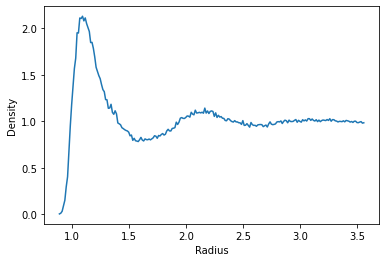

In [3]:
### Soft Sphere Molecular Dynamics Program ###
########### Prof. Michael Colvin #############
######## School of Natural Sciences ##########
#################### and #####################
############### Josh Phillips ################
########### School of Engineering ############
################# UC Merced ##################

#Computational core and some parameter names based closely on mdss.f program in
#Molecular Dynamics Simulation by J.M. Haile, John Wiley & Sons, 1992

#Set Simulation parameters and system state
#Addition control parameters located at the top of the class definition for system

#Set system state
NAtom= 216 #108            #Number of atoms

# Set density and temperatures (g/cm^3 and K)
Dens= 1.0 #2.0:solid
Temp= 150

# Convert to dimensionless units
epsilon_K=119.4
Density=Dens/1.68247            #Density  (1.0=1.68247 g/cm^3)
Temperature=Temp/epsilon_K      #Temperature (1.0=epsilon_K)

#Set number of equilibration and simulation time steps
MaxEqb=500
MaxStep=1000

#Import necessary modules
import random
import math, sys, string, time
import matplotlib.pyplot as plt

### Class to manage 3-D points ###
class point:
    def __init__(self):
        self.x=0.0
        self.y=0.0
        self.z=0.0
    def set(self,x,y,z):
        self.x=x
        self.y=y
        self.z=z
    def __mul__(self,scale):
        bpoint=point()
        bpoint.set(self.x*scale,self.y*scale,self.z*scale)
        return bpoint
    def __rmul__(self,scale):
        bpoint=point()
        bpoint.set(self.x*scale,self.y*scale,self.z*scale)
        return bpoint
    def __div__(self,scale):
        bpoint=point()
        bpoint.set(self.x/scale,self.y/scale,self.z/scale)
        return bpoint
    def __imul__(self,scale):
        self.x*=scale
        self.y*=scale
        self.z*=scale
        return self
    def __sub__(self,apoint):
        bpoint=point()
        bpoint.set(self.x-apoint.x,self.y-apoint.y,self.z-apoint.z)
        return bpoint
    def __add__(self,apoint):
        bpoint=point()
        bpoint.set(self.x+apoint.x,self.y+apoint.y,self.z+apoint.z)
        return bpoint
    def __isub__(self,apoint):
        self.x-=apoint.x
        self.y-=apoint.y
        self.z-=apoint.z
        return self
    def __iadd__(self,apoint):
        self.x+=apoint.x
        self.y+=apoint.y
        self.z+=apoint.z
        return self
    def sqmag(self):
        return self.x**2+self.y**2+self.z**2
    def dot(self,apoint):
        #return ((self.x*apoint.x+self.y*apoint.y+self.z*apoint.z)/math.sqrt(self.sqmag()*apoint.sqmag()))
        return (self.x*apoint.x+self.y*apoint.y+self.z*apoint.z)
    def copy(self,apoint):
        self.x=apoint.x
        self.y=apoint.y
        self.z=apoint.z
    def printpoint(self):
        print((self.x,self.y,self.z))
    def dist(self,apoint):
        return math.sqrt((self.x-apoint.x)**2+(self.y-apoint.y)**2+(self.z-apoint.z)**2)

### Class to manage atom objects ###
class atom:
    def __init__(self):
        self.pos=point()
        self.vel=point()
        self.accel=point()
        self.deriv3=point()
        self.deriv4=point()
        self.deriv5=point()
        self.force=point()
        self.neighbors=[]
        self.diffusion=[]
        self.diffusion2=[]
        self.pastvels=[]
        self.vels=[]
        self.velautolen=0
        self.velautonorm=0
        self.velautocount=0
        self.velautocorr=[]
        self.posoffset=point()
        self.diffstep=0
        self.diffdenom=0
        self.diffref=point()
        self.visckxy=0
        self.visckyz=0
        self.visckzx=0
        self.visckxx=0
        self.visckyy=0
        self.visckzz=0
        self.viscpxy=0
        self.viscpyz=0
        self.viscpzx=0
        self.viscpxx=0
        self.viscpyy=0
        self.viscpzz=0
    def setpos(self,x,y,z):
        self.pos.x=x
        self.pos.y=y
        self.pos.z=z
    def setvel(self,x,y,z):
        self.vel.x=x
        self.vel.y=y
        self.vel.z=z
    def velsqmag(self):
        return self.vel.sqmag()
    def diffuse(self,diffmax):
        position=self.pos+self.posoffset
        if self.diffstep==diffmax or self.diffstep==0:
            self.diffstep=0
            self.diffref.copy(position)
            self.diffdenom+=1
        distance=self.diffref.dist(position)
        self.diffusion[self.diffstep]+=distance
        self.diffusion2[self.diffstep]+=distance*distance
        self.diffstep+=1
    def diffusecalc(self,diffmax):
        for i in range(diffmax):
            if i < self.diffstep:
                self.diffusion[i]/=self.diffdenom
                self.diffusion2[i]/=self.diffdenom
            else:
                self.diffusion[i]/=(self.diffdenom-1)
                self.diffusion2[i]/=(self.diffdenom-1)
    def diffinit(self,diffmax):
        self.diffstep=0
        for i in range(diffmax):
            self.diffusion.append(0.)
            self.diffusion2.append(0.)
    def velautoinit(self,velautolen):
        self.velautolen=velautolen
        self.velautocount=0
        self.velautonorm=0
        for i in range(velautolen):
            self.velautocorr.append(0.)
    def velautoupdate(self):
        velocity=point()
        velocity.copy(self.vel)
        if self.velautocount<self.velautolen:
            self.velautocount+=1
            self.vels.append(velocity)
        else:
            self.vels.pop(0)
            self.vels.append(velocity)
            self.velautonorm+=1
            icount=1
            for ivel in self.vels:
                self.velautocorr[self.velautolen-icount]+=ivel.dot(self.vel)
                icount+=1
    def visckupdate(self):
        self.visckxy=self.vel.x*self.vel.y
        self.visckyz=self.vel.y*self.vel.z
        self.visckzx=self.vel.z*self.vel.x
        self.visckxx=self.vel.x*self.vel.x
        self.visckyy=self.vel.y*self.vel.y
        self.visckzz=self.vel.z*self.vel.z
    def viscpclear(self):
        self.viscpxy=0
        self.viscpyz=0
        self.viscpzx=0
        self.viscpxx=0
        self.viscpyy=0
        self.viscpzz=0
    def getpos(self):
        return self.pos
    def getvel(self):
        return self.vel
    def printatom(self):
        print('Position:')
        self.pos.printpoint()
        print('Velocity:')
        self.vel.printpoint()
    def periodic(self,low,high,width):
        if (self.pos.x<low):
            self.pos.x+=width
            self.posoffset.x-=width
        if (self.pos.x>high):
            self.pos.x-=width
            self.posoffset.x+=width
        if (self.pos.y<low):
            self.pos.y+=width
            self.posoffset.y-=width
        if (self.pos.y>high):
            self.pos.y-=width
            self.posoffset.y+=width
        if (self.pos.z<low):
            self.pos.z+=width
            self.posoffset.z-=width
        if (self.pos.z>high):
            self.pos.z-=width
            self.posoffset.z+=width

### Functions to carry out linear regression ###
def mean_sd(xlist):
    n=len(xlist)
    sumx=0
    sumx2=0
    icount=0
    for x in xlist:
        icount+=1
        sumx+=x
        sumx2+=x*x
    mean=sumx/float(n)
    sd=math.sqrt((sumx2-sumx*sumx/float(n))/float(n-1))
    return mean,sd
def regression(xlist,ylist):
    n=len(xlist)
    if n!=len(ylist):
        print('Differing list lengths in regression')
        exit(1)
    meanx,sdx=mean_sd(xlist)
    meany,sdy=mean_sd(ylist)
    r=0
    for i in range(n):
        r+=(xlist[i]-meanx)*(ylist[i]-meany)
    r/=sdx*sdy*float(n-1)
    r2=r*r
    slope=r*sdy/sdx
    intercept=meany-slope*meanx
    return slope,intercept,r2


### Class to manage simulation system ###
class system:
    def __init__(self):

        #Set system state
        self.NAtom=NAtom
        self.Density=Density
        self.Temp=Temperature

        #Set
        self.MaxEqb=MaxEqb    #Number of equilibration timesteps
        self.MaxStep=MaxStep   #Number of production run timesteps
        self.Ndead=0      #Number of non-scaled steps at end of equil

        #Simulation parameters and flags
        self.Step=0.004   #Integration time step
        self.RCut=4.0     #Distance cutoff

        #Set simulation frequencies
        self.Ksample=10   #Freq of calculating properties
        self.Kwrite=20    #Freq (timesteps) of writing properties
        self.Krdf=1000    #Freq of calculating radial dist function (=0 for no Rdf)
        self.Kcrd=0       #Freq of saving structure to crd file (=0 for no crd)
        self.Kvel=0       #Freq of writing out velocities (=0 to not write velocities)
        self.Kdiffuse=0   #Not zero to calc diffusion const by Einstein relationship
        self.Kvelauto=0   #Not zero to calc diffusion const by vel autocorrelation (slow!)
        self.Kviscauto=0  #Not zero to calc shear viscosity autocorrelation
        self.Ksort=10     #Freq of updating neighborlist--this should be tested!
        self.KHprint=0    #Not zero to print velocity distributions used to calc H-function

        #Set up scaling (only occurs during equilibration)
        self.Lener=0   #Set to 1 to turn on Energy scaling
        self.Dener=-2  #Set total energy for energy scaling
        self.LScale=1  #Set to 1 to turn on Temperature scaling
        if self.Lener!=0 and self.LScale!=0:
            print('Warning--Energy scaling overriding Temperature scaling')
            self.LScale=0

        #Set up shifted force potential
        self.LShift=0  #Set to 1 to use shifted force potential

        ####################################################################
        # No user settings after this line #################################
        ####################################################################

        #Initialize timestep counter
        self.NStep=0

        #Initialize atom list
        self.atoms=[]
        for i in range(self.NAtom):
            self.atoms.append(atom())

        #Calculate system parameters
        self.InvStep=1./self.Step
        self.StepSq=self.Step*self.Step
        self.HlfStepSq=0.5*self.Step*self.Step
        self.Vol=self.NAtom/self.Density
        self.Cube=self.Vol**(1./3.)
        self.HlfCube=0.5*self.Cube
        self.RList=self.RCut+0.3
        if self.RList>self.HlfCube:
            self.RList=self.HlfCube
        if self.RCut>self.HlfCube:
            self.RCut=self.HlfCube-0.35
        self.AHeat=3.*self.NAtom*self.StepSq*self.Temp

        #Parameters for predictor-corrector integrator
        self.Alfa0=3./16.
        self.Alfa1=251./360.
        self.Alfa3=11./18.
        self.Alfa4=1./6.
        self.Alfa5=1./60.

        #Force shifted constants
        self.RCutInv=1./self.RCut
        self.RCut6Inv=self.RCutInv**6
        self.EShift=self.RCut6Inv*(28.-52.*self.RCut6Inv)
        self.FShift=48.*self.RCutInv*self.RCut6Inv*(self.RCut6Inv-0.5)

        #Long-range pressure and energy corrections
        self.RCut3=self.RCut**3
        self.RCut9=self.RCut3**3
        self.ETail=8.*math.pi*self.Density*(1./(9.*self.RCut9)-1./(3.*self.RCut3))
        self.VTail=96.*math.pi*self.Density*(.5/(3.*self.RCut3)-1./(9.*self.RCut9))

        self.VMax=5.
        self.VDel=0.05
        self.NVDels=int(2.*self.VMax/self.VDel+1.01)
        self.NVin=[]
        self.Vbinsave=[]
        self.Vbinsum=0
        for i in range(self.NVDels):
            self.NVin.append(point())
            self.Vbinsave.append(point())

        self.Energy=0.
        self.Virial=0.
        self.SumEnergy=0.
        self.SumVirial=0.
        self.SumVelSq=0.
        self.PressAve=0.
        #Initialize Radial Distribution Function
        #self.NRDF=300
        self.RDel=self.HlfCube/300.
        self.NRDels=int(self.HlfCube/self.RDel-1)
        self.RadialDist=[]
        self.NRadialDist=[]
        for i in range(self.NRDels):
            self.RadialDist.append(0.0)
            self.NRadialDist.append(0)

        #Flags and variables for writing trajectory
        self.crdfile=0
        self.labelatom=1

        #Flags and variables for writing velocities
        self.velfile=0
        self.openvelfile=1

        #Flags and initialization for calculating diffusion constant
        if self.Kdiffuse!=0:
            self.diffmax=1000
            if self.diffmax>self.MaxStep:
                print("WARNING--MaxStep is less than diffmax (%d)"%self.diffmax)
                print("Turning off diffusion calculation")
                self.Kdiffuse=0
            self.diffconst=0.
            for iatom in self.atoms:
                iatom.diffinit(self.diffmax)

        #Flags and initialization for calculating velocity autocorrelation function
        if self.Kvelauto!=0:
            self.velautolen=400
            if self.velautolen>self.MaxStep:
                print("WARNING--MaxStep is less than velautolen (%d)"%self.velautolen)
                print("Turning off velocity autocorrelation calculation")
                self.Kvelauto=0
            self.velautocorrave=[]
            for iatom in self.atoms:
                iatom.velautoinit(self.velautolen)

        #Flags and initialization for calculating shear viscosity autocorrelation
        if self.Kviscauto!=0:
            self.Jautolen=400
            self.Jautocount=0
            self.Jautonorm=0
            self.Jxyvals=[]
            self.Jyzvals=[]
            self.Jzxvals=[]
            self.Jxy=0
            self.Jyz=0
            self.Jzx=0
            self.Jxx=0
            self.Jyy=0
            self.Jzz=0
            self.Jautocorr=[]
            for i in range(self.Jautolen):
                self.Jautocorr.append(0.)

        #Initialize averages for the H-function
        self.Have=0.0
        self.Hcount=0


    ### Functions for initializing the system ###
    def setfcc(self):
        #Set number of lattice units
        NUnit=int((self.NAtom/4.)**(1./3.)+.1)
        NCheck=int(4.*(NUnit**3))
        while(NCheck<self.NAtom):
            NUnit+=1
            NCheck=4.*(NUnit**3)
        self.Dist=0.5*self.Cube/NUnit

        #Set positions of first 4 atoms
        self.atoms[0].setpos(0.,0.,0.)
        self.atoms[1].setpos(0.,self.Dist,self.Dist)
        self.atoms[2].setpos(self.Dist,0.,self.Dist)
        self.atoms[3].setpos(self.Dist,self.Dist,0.)

        #Replicate this unit cell throughout the volume
        m=0
        kct=0
        for i in range(NUnit):
            for j in range(NUnit):
                for k in range(NUnit):
                    for ij in range(4):
                        if kct<self.NAtom:
                            self.atoms[ij+m].setpos(self.atoms[ij].pos.x+2.*self.Dist*i,
                                                    self.atoms[ij].pos.y+2.*self.Dist*j,
                                                    self.atoms[ij].pos.z+2.*self.Dist*k)
                        kct+=1
                    m+=4

    def setvel(self):
        #random.seed(12345)

        sum=point()
        for iatom in self.atoms:
            iatom.setvel(random.random(),random.random(),random.random())
            sum+=iatom.vel
        #sum.printpoint()
        self.VelSq=0.0
        for iatom in self.atoms:
            iatom.vel-=sum*(1.0/self.NAtom)
            self.VelSq+=iatom.velsqmag()

        #Scale velocities
        self.scalevel(0.)

    def scalevel(self,Dener):
        Factor=math.sqrt(self.AHeat/self.VelSq)
        if self.Lener:
            EPot=self.Energy/self.NAtom+self.ETail
            DEK=Dener-EPot
            Factor=math.sqrt(2.*self.NAtom*DEK*self.StepSq/self.VelSq)
        for iatom in self.atoms:
            iatom.vel*=Factor

    ### Functions for molecular dynamics updates ###
    def predictor(self):
        for iatom in self.atoms:
            iatom.pos+=iatom.vel+iatom.accel+iatom.deriv3+iatom.deriv4+iatom.deriv5
            iatom.vel+=2.*iatom.accel+3.*iatom.deriv3+4.*iatom.deriv4+5.*iatom.deriv5
            iatom.accel+=3.*iatom.deriv3+6.*iatom.deriv4+10.*iatom.deriv5
            iatom.deriv3+=4.*iatom.deriv4+10.*iatom.deriv5
            iatom.deriv4+=5.*iatom.deriv5
            iatom.force.set(0.,0.,0.)

    def evalforce(self):
        self.Energy=0.
        self.Virial=0.
        self.LUpdate=0
        if not self.NStep%self.Ksort:
            self.LUpdate=1

        self.Jxy=0.0
        self.Jyz=0.0
        self.Jzx=0.0
        self.Jxx=0.0
        self.Jyy=0.0
        self.Jzz=0.0
        for i in range(self.NAtom):
            self.atoms[i].visckupdate()
            self.atoms[i].viscpclear()
            self.forceloop(i)
            self.Jxy+=self.atoms[i].visckxy+self.atoms[i].viscpxy
            self.Jyz+=self.atoms[i].visckyz+self.atoms[i].viscpyz
            self.Jzx+=self.atoms[i].visckzx+self.atoms[i].viscpzx
            self.Jxx+=self.atoms[i].visckxx+self.atoms[i].viscpxx
            self.Jyy+=self.atoms[i].visckyy+self.atoms[i].viscpyy
            self.Jzz+=self.atoms[i].visckzz+self.atoms[i].viscpzz


    def forceloop(self,iatom):
        #If LUpdate is true loop over all atoms and update neighbor list
        if self.LUpdate:
            #print 'In LUpdate, NStep=%d'%(self.NStep)
            self.atoms[iatom].neighbors=[]
            for jatom in range(iatom+1,self.NAtom):
                diff=self.atoms[iatom].pos-self.atoms[jatom].pos
                if diff.x< -self.HlfCube: diff.x+=self.Cube
                if diff.x> self.HlfCube: diff.x-=self.Cube
                if diff.y< -self.HlfCube: diff.y+=self.Cube
                if diff.y> self.HlfCube: diff.y-=self.Cube
                if diff.z< -self.HlfCube: diff.z+=self.Cube
                if diff.z> self.HlfCube: diff.z-=self.Cube
                Rsq=diff.sqmag()
                Rij=math.sqrt(Rsq)
                if self.LUpdate and Rij<self.HlfCube:
                    #Update the radial distribution function
                    NShell=int(Rij/self.RDel+.5)
                    if (NShell<=self.NRDels):
                        self.NRadialDist[NShell-1]+=1
                        if Rij<self.RList:
                            atomnum=jatom
                            self.atoms[iatom].neighbors.append(atomnum)
                if Rij<self.RCut:
                    RSqInv=1./Rsq
                    R6Inv=RSqInv**3
                    Energy=4.*R6Inv*(R6Inv-1.)
                    Force=RSqInv*48.*R6Inv*(R6Inv-0.5)
                    if self.LShift:
                        Energy+=self.EShift+Rij*self.FShift
                        Force-=RSqInv*Rij*self.FShift
                    fd=Force*diff
                    self.atoms[iatom].force+=fd
                    self.atoms[jatom].force-=fd
                    self.atoms[iatom].viscpxy+=diff.y*fd.x
                    self.atoms[iatom].viscpyz+=diff.z*fd.y
                    self.atoms[iatom].viscpzx+=diff.x*fd.z
                    self.atoms[iatom].viscpxx+=diff.x*fd.x
                    self.atoms[iatom].viscpyy+=diff.y*fd.y
                    self.atoms[iatom].viscpzz+=diff.z*fd.z
                    self.Energy+=Energy
                    self.Virial-=Force*Rsq

        #If LUpdate is false, just loop over atoms in neighbor list
        else:
            for jatom in self.atoms[iatom].neighbors:
                diff=self.atoms[iatom].pos-self.atoms[jatom].pos
                if diff.x< -self.HlfCube: diff.x+=self.Cube
                if diff.x> self.HlfCube: diff.x-=self.Cube
                if diff.y< -self.HlfCube: diff.y+=self.Cube
                if diff.y> self.HlfCube: diff.y-=self.Cube
                if diff.z< -self.HlfCube: diff.z+=self.Cube
                if diff.z> self.HlfCube: diff.z-=self.Cube
                Rsq=diff.sqmag()
                Rij=math.sqrt(Rsq)

                if Rij<self.RCut:
                    RSqInv=1./Rsq
                    R6Inv=RSqInv**3
                    Energy=4.*R6Inv*(R6Inv-1.)
                    Force=RSqInv*48.*R6Inv*(R6Inv-0.5)
                    if self.LShift:
                        Energy+=self.EShift+Rij*self.FShift
                        Force-=RSqInv*Rij*self.FShift
                    fd=Force*diff
                    self.atoms[iatom].force+=fd
                    self.atoms[jatom].force-=fd
                    self.atoms[iatom].viscpxy+=diff.y*fd.x
                    self.atoms[iatom].viscpyz+=diff.z*fd.y
                    self.atoms[iatom].viscpzx+=diff.x*fd.z
                    self.atoms[iatom].viscpxx+=diff.x*fd.x
                    self.atoms[iatom].viscpyy+=diff.y*fd.y
                    self.atoms[iatom].viscpzz+=diff.z*fd.z
                    self.Energy+=Energy
                    self.Virial-=Force*Rsq

    def corrector(self):
        for iatom in self.atoms:
            error=self.HlfStepSq*iatom.force-iatom.accel
            iatom.pos+=error*self.Alfa0
            iatom.vel+=error*self.Alfa1
            iatom.accel+=error
            iatom.deriv3+=error*self.Alfa3
            iatom.deriv4+=error*self.Alfa4
            iatom.deriv5+=error*self.Alfa5

            #Apply periodic boundary conditions
            iatom.periodic(0.,self.Cube,self.Cube)

    def scaleforces(self):
        for iatom in self.atoms:
            iatom.force*=self.HlfStepSq

    ### Functions related to updating and printing standard system parameters and properties ###
    def printparam(self):
        print('Molecular Dynamics for %d LJ Atoms'%(self.NAtom))
        if self.Lener:
            print('Using energy scaling to set point=%lf during equilibration'%(self.dener))
        else:
            print('Using Temperature scaling during equilibration')
        if self.LShift:
            print('Fixed Density with shift-force potential')
        else:
            print('Fixed Density with truncated potential')
        #print('Density=%7.3lf, Temperature=%7.3lf'%(self.Density, self.Temp))
        density_cgs=self.Density*1.68247
        temperature_cgs=self.Temp*epsilon_K
        print('Density=%7.3lf (g/cm^3)  Temperature=%7.3lf (K)'\
              %(density_cgs,temperature_cgs))
        print('Timestep=%6.3lf'%(self.Step))
        #print 'Cube side=%7.3lf, Cube side/2=%7.3lf'%(self.Cube,self.HlfCube)
        #print 'RCut=%7.3lf, RList=%7.3lf'%(self.RCut, self.RList)

        ALamda,ALam1=self.orderparameter()
        #print 'Order parameter=%7.3lf'%(ALam1)

    def resetprop(self):
        self.SumEnergy=0.
        self.SumVirial=0.
        self.SumVelSq=0.
        for i in range(self.NRDels):
            self.NRadialDist[i]=0
        for i in self.Vbinsave:
            i.set(0.,0.,0.)
        self.Vbinsum=0

    def properties(self):
        self.VelSq=0.0
        for iatom in self.atoms:
            self.VelSq+=iatom.vel.sqmag()
        self.SumEnergy+=self.Energy
        self.SumVirial+=self.Virial
        self.SumVelSq+=self.VelSq

    def printproplabel(self):
        print('    Step   Etotal       Temp    <Temp>    Epot     <Epot>     Press    <Press>')
        #print '    Step   Etotal       Temp    <Temp>    Epot     <Epot>     Press    <Press>   Lambda   H'

    def printproperties(self,samplefreq):
        Ekin=self.VelSq/(2.*self.NAtom*self.StepSq)
        Epot=self.Energy/self.NAtom+self.ETail
        Etotal=Ekin+Epot
        Temp=2.*Ekin/3.
        Pressure=self.Density*(Temp-self.Virial/(3.*self.NAtom)-self.VTail/3.)

        Denom=self.NAtom*float(self.NStep/samplefreq)
        EkAve=self.SumVelSq/(2.*Denom*self.StepSq)
        EpAve=self.SumEnergy/Denom+self.ETail
        self.TempAve=2.*EkAve/3.
        self.PressAve=self.Density*(self.TempAve-self.SumVirial/(3.*Denom)-self.VTail/3.)

        ALamda,ALam1=self.orderparameter()
        Hinst=self.Hfunction()
        self.Have+=Hinst
        self.Hcount+=1
        #print 'VelSq=%lf'%(self.VelSq/(float(self.NAtom)*self.StepSq))
        print('  %6d  %8.5lf %9.4lf %9.4lf %9.4lf %9.4lf %9.4lf %9.4lf'\
              %(self.NStep,Etotal,Temp,self.TempAve,Epot,EpAve,Pressure,self.PressAve))
        #print '  %6d  %8.5lf %9.4lf %9.4lf %9.4lf %9.4lf %9.4lf %9.4lf %7.3lf %7.3lf'\
        #      %(self.NStep,Etotal,Temp,self.TempAve,Epot,EpAve,Pressure,self.PressAve,ALam1,Hinst)


    ### Function for calculating the order parameter ###
    def orderparameter(self):
        Pi4D=4.*math.pi/self.Dist
        ALamda=0.
        ALam1=0.

        for i in range(self.NAtom):
            ALamda+=math.cos(Pi4D*self.atoms[i].pos.x)\
                     +math.cos(Pi4D*self.atoms[i].pos.y)+math.cos(Pi4D*self.atoms[i].pos.z)

            if i:
                ALam1+=math.cos(Pi4D*(self.atoms[i].pos.x-self.atoms[0].pos.x))\
                        +math.cos(Pi4D*(self.atoms[i].pos.y-self.atoms[0].pos.y))\
                        +math.cos(Pi4D*(self.atoms[i].pos.z-self.atoms[0].pos.z))
        ALamda/=(3.*self.NAtom)
        ALam1/=(3.*(self.NAtom-1))
        return ALamda,ALam1

    ### Functions related to Boltzman H-function ###
    def TheoryHfunc(self):
        return(-self.VDel/2.*(math.log(self.TempAve)-2.*math.log(self.VDel)+math.log(math.pi)+math.log(2.)+1.))

    def Hfunction(self):
        for iNVin in self.NVin:
            iNVin.set(0,0,0)
        Vfact=self.VDel*self.Step
        Offset=1.5+self.VMax/self.VDel
        for iatom in self.atoms:
            if abs(iatom.vel.x)<self.VMax:
                NShell=int(iatom.vel.x/Vfact+Offset)
                #print 'NShell=%d'%(NShell)
                if NShell>0 and NShell<self.NVDels:
                    self.NVin[NShell-1].x+=1
                NShell=int(iatom.vel.y/Vfact+Offset)
                #print 'NShell=%d'%(NShell)
                if NShell>0 and NShell<self.NVDels:
                    self.NVin[NShell-1].y+=1
                NShell=int(iatom.vel.z/Vfact+Offset)
                #print 'NShell=%d'%(NShell)
                if NShell>0 and NShell<self.NVDels:
                    self.NVin[NShell-1].z+=1

        HH=0.
        #sum=point()
        icount=0
        self.Vbinsum+=1
        for iNVin in self.NVin:
            self.Vbinsave[icount]+=iNVin
            icount+=1
            #iNVin.printpoint()
            #sum+=iNVin
            if iNVin.x>0:
                FoFV=float(iNVin.x)/self.NAtom
                HH+=FoFV*math.log(FoFV)
            if iNVin.y>0:
                FoFV=float(iNVin.y)/self.NAtom
                HH+=FoFV*math.log(FoFV)
            if iNVin.z>0:
                FoFV=float(iNVin.z)/self.NAtom
                HH+=FoFV*math.log(FoFV)
        Hinst=HH*self.VDel/3.

        if self.KHprint:
            Hfile=open('H.txt','w')
            print('Vdel=%lf Step=%lf Vbinsum=%d'%(self.VDel,self.Step,self.Vbinsum), file=Hfile)
            for iNVin in self.Vbinsave:
                print('%d %d %d'%(iNVin.x,iNVin.y,iNVin.z), file=Hfile)
            Hfile.close()
            #self.Hprint=0

        return Hinst

    ### Functions related to Radial distribution function ###
    def radialdist(self,stepnumber):
        self.rdf=[]
        self.rdist=[]
        rdffilename='rdf.%05d.xvd'%(stepnumber)
        self.rdffile=open(rdffilename,'w')
        print('#Radial Dist Function at time=%d'%(stepnumber), file=self.rdffile)
        print('#Natom=%d, Density=%lf, Ave Temp=%lf'%(self.NAtom, self.Density, self.TempAve), file=self.rdffile)
        print('#R  G(r)', file=self.rdffile)
        print('@  title \"Mean square displacement\"', file=self.rdffile)
        print('@  xaxis label \"Radius (sigma)"', file=self.rdffile)
        print('@  yaxis label \"Particle density\"', file=self.rdffile)


        #NRDels=min(NRDels,self.NRDF)
        Origins=(float(self.NStep)/float(self.Ksort))*(self.NAtom/2.)

        for i in range(self.NRDels):
            self.RadialDist[i]=0.0
            if (self.NRadialDist[i]>0):
                Radius=self.RDel*(i+1)
                VolShell=4.*math.pi*self.RDel*Radius*Radius+(math.pi*self.RDel**3)/3.
                self.RadialDist[i]=self.NRadialDist[i]/(self.Density*Origins*VolShell)
                print('%7.3lf %8.5lf'\
                                    %(Radius,self.RadialDist[i]), file=self.rdffile)
                self.rdf.append(self.RadialDist[i])
                self.rdist.append(Radius)
        self.rdffile.close()

    ### Functions related to printing .pdb and .crd trajectory files ###
    def printpdb(self):
        pdbfile=open('ar.pdb','w')
        print('COMMENT SYSTEM OF ARGON ATOMS', file=pdbfile)
        icount=1
        for iatom in self.atoms:
            if self.labelatom and icount==1:
                print('ATOM  %5d  AR               %8.3lf%8.3lf%8.3lf'%(icount,iatom.pos.x,iatom.pos.y,iatom.pos.z), file=pdbfile)
            else:
                print('ATOM  %5d  AR               %8.3lf%8.3lf%8.3lf'%(icount,iatom.pos.x,iatom.pos.y,iatom.pos.z), file=pdbfile)
            icount+=1
        pdbfile.close()

    def startcrd(self):
        self.crdfile=open('ar.mdcrd','w')
        print('CRD FILE ARGON ATOMS', file=self.crdfile)
        print('%5d'%(self.NAtom), file=self.crdfile)
        for i in range(0,self.NAtom,2):
            print('%12.7lf%12.7lf%12.7lf%12.7lf%12.7lf%12.7lf'%(self.atoms[i].pos.x,
                                                                                self.atoms[i].pos.y,
                                                                                self.atoms[i].pos.z,
                                                                                self.atoms[i+1].pos.x,
                                                                                self.atoms[i+1].pos.y,
                                                                                self.atoms[i+1].pos.z), file=self.crdfile)
    def printcrd(self):
        for i in range(0,self.NAtom,2):
            print('%12.7lf%12.7lf%12.7lf%12.7lf%12.7lf%12.7lf'%(self.atoms[i].pos.x,
                                                                                   self.atoms[i].pos.y,
                                                                                   self.atoms[i].pos.z,
                                                                                   self.atoms[i+1].pos.x,
                                                                                   self.atoms[i+1].pos.y,
                                                                                   self.atoms[i+1].pos.z), file=self.crdfile)

    ### Functions related to calculating the diffusion constant by Einstein relation ###
    def diffuseupdate(self):
        for iatom in self.atoms:
            iatom.diffuse(self.diffmax)

    def diffuseave(self):
        self.difffile=open('diffusion.xvg','w')
        diffave=[]
        diffave2=[]
        for i in range(self.diffmax):
            diffave.append(0.)
            diffave2.append(0.)
        for iatom in self.atoms:
            iatom.diffusecalc(self.diffmax)
            for i in range(self.diffmax):
                diffave[i]+=iatom.diffusion[i]
                diffave2[i]+=iatom.diffusion2[i]
        for i in range(self.diffmax):
            diffave[i]/=float(self.NAtom)
            diffave2[i]/=float(self.NAtom)
        print('#Mean square displacement of all atoms', file=self.difffile)
        print('#Time     <r2>', file=self.difffile)
        print('@  title \"Mean square displacement\"', file=self.difffile)
        print('@  xaxis label \"Time (reduced time units)\"', file=self.difffile)
        print('@  yaxis label \"Mean square displacement (sigma^2)\"', file=self.difffile)
        for i in range(self.diffmax):
            print('%8.4lf %8.4lf'%(i*self.Step,diffave2[i]), file=self.difffile)
        self.difffile.close()
        #Fit linear regression line to <r^2>=6Dt
        time=[]
        for i in range(self.diffmax):
            time.append(i*self.Step)
        slope,intercept,r2=regression(time,diffave2)
        print('displace^2 vs t: slope=%lf intercept=%lf R2=%lf'\
              %(slope,intercept,r2))
        self.diffconst=slope/6.
        print('Diffusion constant from Einstein relation=%lf (reduced units)'%(self.diffconst))
        diffusion_cgs=self.diffconst*0.1344*self.Step*100000.
        print('Diffusion constant from Einstein relation=%lf (x10-5 cm^2/sec)'%(diffusion_cgs))

    ### Functions related to calculating the diffusion constant velocity autocorrelation ###
    def velautoupdate(self):
        for iatom in self.atoms:
            iatom.velautoupdate()

    def velautocorr(self):
        velautosum=0.0
        self.velautocorrave=[]
        for i in range(self.velautolen):
            self.velautocorrave.append(0)
        for iatom in self.atoms:
            for i in range(self.velautolen):
                self.velautocorrave[i]+=iatom.velautocorr[i]/float(iatom.velautonorm)
        for i in range(self.velautolen):
            self.velautocorrave[i]/=(self.StepSq*self.NAtom)
            velautosum+=self.velautocorrave[i]*self.Step
        self.autodiffconst=velautosum/3.

    def printvelautocorr(self):
        velautofile=open('velautocorr.xvd','w')
        print('#Velocity Autocorrelation Function', file=velautofile)
        print('#Time     <r2>', file=velautofile)
        print('@  title \"Velocity Autocorrelation Function\"', file=velautofile)
        print('@  xaxis label \"Time (reduced time units)\"', file=velautofile)
        print('@  yaxis label \"V*V\"', file=velautofile)
        for i in range(self.velautolen):
            print('%12.8lf %12.8lf'%(i*self.Step,self.velautocorrave[i]), file=velautofile)
        velautofile.close()

    def viscautoupdate(self):
        Jxy=self.Jxy
        Jyz=self.Jyz
        Jzx=self.Jzx
        if self.Jautocount<self.Jautolen:
            self.Jautocount+=1
            self.Jxyvals.append(Jxy)
            self.Jyzvals.append(Jyz)
            self.Jzxvals.append(Jzx)
        else:
            self.Jxyvals.pop(0)
            self.Jyzvals.pop(0)
            self.Jzxvals.pop(0)
            self.Jxyvals.append(Jxy)
            self.Jyzvals.append(Jyz)
            self.Jzxvals.append(Jzx)
            self.Jautonorm += 1
            for i in range(self.Jautolen):
                self.Jautocorr[self.Jautolen-i-1] += ((self.Jxyvals[i] * Jxy) +
                                                      (self.Jyzvals[i] * Jyz) +
                                                      (self.Jzxvals[i] * Jzx))

    def viscautocorr(self):
        for i in range(self.Jautolen):
            self.Jautocorr[i] *= 2.35e-7 / (self.StepSq * float(self.Jautonorm) * float(self.NAtom))

    def printviscautocorr(self):
        viscautofile=open('viscautocorr.xvd','w')
        print('#Mean square displacement of all atoms', file=viscautofile)
        print('#Time     <r2>', file=viscautofile)
        print('@  title \"Mean square displacement\"', file=viscautofile)
        print('@  xaxis label \"Time (reduced time units)\"', file=viscautofile)
        print('@  yaxis label \"J*J\"', file=viscautofile)
        for i in range(self.Jautolen):
            print('%12.8lf %12.8lf'%(i*self.Step,self.Jautocorr[i]), file=viscautofile)
        viscautofile.close()

    ### Functions for printing debugging information ###
    def printsystem(self):
        print('NAtoms=%d'%(self.NAtom))
        for iatom in self.atoms:
            iatom.printatom()

    def printvels(self):
        if self.openvelfile:
            self.velfile=open('vel.txt','w')
            self.openvelfile=0
        for iatom in self.atoms:
            print('%12.8lf %12.9lf %12.8lf'%(iatom.vel.x/self.Step,iatom.vel.y/self.Step,iatom.vel.z/self.Step), file=self.velfile)


###### Run Simulations #######
# Set temperature and density from command line if arguments are given
#if (len(sys.argv)==2):
#    Temperature=float(sys.argv[1])/1000.
#    #print('Using specified temp=%f and default density=%f'%(Temperature, Density))
#elif (len(sys.argv)==3):
#    Temperature=float(sys.argv[1])/1000.
#    Density=float(sys.argv[2])/1000.
    #print('Using specified temperature=%f and density=%f'%(Temperature, Density))
#else:
    #print('Using default temperature=%f and density=%f'%(Temperature, Density))

###### Start timing ######
#start_time=time.clock()
###### Setup Simulations #######
asystem=system()
asystem.setfcc()
asystem.setvel()
asystem.printparam()
asystem.evalforce()
asystem.scaleforces()
asystem.printproplabel()

###### Run Equilibration #######
for asystem.NStep in range(1,asystem.MaxEqb+1):
    asystem.predictor()
    asystem.evalforce()
    asystem.corrector()
    asystem.properties() #Calculate the properties every step during equil
    if not asystem.NStep%asystem.Kwrite:
        asystem.printproperties(1)
    if asystem.NStep < (asystem.MaxEqb-asystem.Ndead):  #Don't scale for last Ndead steps
        if asystem.LScale or asystem.Lener:
            asystem.scalevel(asystem.Dener)

#equil_time=time.clock()
###### Run Simulation #######
print('Starting Production run')
asystem.resetprop()
asystem.printproplabel()
if asystem.Kcrd:
    asystem.printpdb()
    asystem.startcrd()

for asystem.NStep in range(1,asystem.MaxStep+1):
    asystem.predictor()
    asystem.evalforce()
    asystem.corrector()

    if asystem.Kdiffuse:
        asystem.diffuseupdate()

    if not asystem.NStep%asystem.Ksample:
        asystem.properties()
    if not asystem.NStep%asystem.Kwrite:
        asystem.printproperties(asystem.Ksample)

    if asystem.Kvelauto:
        asystem.velautoupdate()
    if asystem.Kviscauto:
        asystem.viscautoupdate()
    if asystem.Kcrd and not asystem.NStep%asystem.Kcrd:
        asystem.printcrd()
    if asystem.Kvel and not asystem.NStep%(asystem.Kvel):
        asystem.printvels()
    if asystem.Krdf and not asystem.NStep%asystem.Krdf:
        asystem.radialdist(asystem.NStep)

#End of loop over production timesteps
#print('Average temperature=%lf (%lf K)'%(asystem.TempAve,asystem.TempAve*119.4))
print("===================================")
print('    Density=%8.3f g/ml'%(Dens))
print('Temperature=%8.3f K'%(asystem.TempAve*epsilon_K))
print('   Pressure=%8.3f bar'%(asystem.PressAve*418.98))
print('     PV/nRT=%8.3f '%(asystem.PressAve*418.98/(1.9858775*Dens*asystem.TempAve*epsilon_K)))
print("===================================")
#print 'H-function average=%lf'%(asystem.Have/asystem.Hcount)
#print 'Theoretical H-function based on average T=%lf'%(asystem.TheoryHfunc())

if asystem.Kdiffuse:
    asystem.diffuseave()
if asystem.Kvelauto:
    asystem.velautocorr()
    asystem.printvelautocorr()
    print('Diffusion constant from vel autocorr=%lf (reduced units)'%(asystem.autodiffconst))
    diffusion_cgs=asystem.autodiffconst*0.1344*asystem.Step*100000.
    print('Diffusion constant from vel autocorr=%lf (x10-5 cm^2/sec)'%(diffusion_cgs))
if asystem.Kviscauto:
    asystem.viscautocorr()
    asystem.printviscautocorr()

#Close files that we've been periodically adding to
if asystem.Kcrd:
    asystem.crdfile.close()
if asystem.Kvel:
    asystem.velfile.close()
plt.xlabel("Radius")
plt.ylabel("Density")
plt.plot(asystem.rdist,asystem.rdf)
plt.show()
#Print timing info
#stop_time=time.clock()
#print("Equilibration time=%.3f minutes"%((equil_time-start_time)/60.))
#print("Production time=%.3f minutes"%((stop_time-equil_time)/60.))
#print("Total run time=%.3f minutes"%((stop_time-start_time)/60.))


### Suggested activity 1
You may want to set density (dens) first to 2.0, and then try a few lower values while keeping temperature at 150 (temp).  It is advisable to keep number of atoms fixed at 108 at first, and then maybe increase it by a factor of 2. Increasing the number of atoms will help get less noisy radial distribution function but will also make the code slower.  Try to get one or two clear examples of each of the three phases, just by varying density.  We will later check your findings against the known phase diagram for a 2D LJ system.

### Suggested activity 2
Find the approximate melting temperature of solid Argon for a given density, say of 1.8. You may want to keep density fixed and try different temperatures within a range of 50-200 for this part.